# CNN

16307110216 Ruian He

### Extract data from downloaded files

As the data is stored in bytes, we need to follow the strcture of the files to extract.

In [1]:
import numpy as np
import gzip,struct,os


'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
'''

def extract_image(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num,row,col = struct.unpack('>4I',buf.read(4*4))
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, file_path))
        image = np.frombuffer(buf.read(num*row*col), dtype=np.uint8)
        return image.reshape(num,row,col).astype(int)
    
'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
'''
    
def extract_label(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num = struct.unpack('>2I',buf.read(2*4))
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, file_path))
        label = np.frombuffer(buf.read(num), dtype=np.uint8)
        return label.astype(int)

Then we do the above approaches on our MNIST dataset.

In [2]:
data_dir = '../mnist'

train_image_file = "train-images-idx3-ubyte.gz"
train_label_file = "train-labels-idx1-ubyte.gz"
test_image_file = "t10k-images-idx3-ubyte.gz"
test_label_file = "t10k-labels-idx1-ubyte.gz"

X_train = extract_image(os.path.join(data_dir,train_image_file))
print('Training data shape: ', X_train.shape)
y_train = extract_label(os.path.join(data_dir,train_label_file))
print('Training labels shape: ', y_train.shape)
X_test = extract_image(os.path.join(data_dir,test_image_file))
print('Test data shape: ', X_test.shape)
y_test = extract_label(os.path.join(data_dir,test_label_file))
print('Test labels shape: ', y_test.shape)

Extracting: ../mnist/train-images-idx3-ubyte.gz
Training data shape:  (60000, 28, 28)
Extracting: ../mnist/train-labels-idx1-ubyte.gz
Training labels shape:  (60000,)
Extracting: ../mnist/t10k-images-idx3-ubyte.gz
Test data shape:  (10000, 28, 28)
Extracting: ../mnist/t10k-labels-idx1-ubyte.gz
Test labels shape:  (10000,)


### Visualize and Preprocess the data

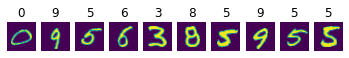

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

choice = np.random.choice(X_test.shape[0],10)
random_image = X_test[choice]
random_label = y_test[choice]

fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(random_label[i])
    ax[i].imshow(random_image[i])
    ax[i].axis('off')

We also can plot the average image for every digit, and get a general view over all training data.

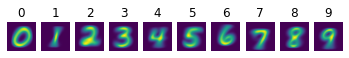

In [4]:
fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(i)
    ax[i].imshow(np.average(X_train[np.where(y_train == i)],axis=0))
    ax[i].axis('off')

In [5]:
# first reshape train data to fit matrix calculus 
X_train = np.reshape(X_train, (X_train.shape[0], 1, 28, 28)) / 256
X_test  = np.reshape(X_test,  (X_test.shape[0],  1, 28, 28)) / 256
print(X_train.shape, X_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)


### CNN
refer to https://github.com/pytorch/examples/blob/master/mnist/main.py

define model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(400, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.avg_pool2d(x, 2)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = F.avg_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

load data to pytorch

In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split

batch_size = 32

X_train_tensor = torch.tensor(X_train,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)
    
dataset = TensorDataset(X_train_tensor,y_train_tensor)
mnist_test = TensorDataset(X_test_tensor,y_test_tensor)
mnist_train, mnist_val = random_split(dataset, [len(dataset)-len(dataset)//5,len(dataset)//5])

train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=12)
val_loader = DataLoader(mnist_val, batch_size=batch_size ,num_workers=12)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=12)

define train and test

In [33]:
from torch.utils.tensorboard import SummaryWriter   

train_writer = SummaryWriter('./runs/train')
val_writer = SummaryWriter('./runs/val')

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += torch.sum(loss)
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    train_writer.add_scalar('Loss', train_loss, epoch)

            
def test(model, device, test_loader, epoch = 0):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if epoch > 0:
        val_writer.add_scalar('Loss', test_loss, epoch)
        val_writer.add_scalar('Accuracy', 100. * correct / len(test_loader.dataset), epoch)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

start training

In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
    
lr = 0.5
gamma = 0.7
epochs = 10

torch.manual_seed(1)
device = torch.device('cuda:0')
model = LeNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader, epoch)
    scheduler.step()

Test set: Average loss: 0.1821, Accuracy: 11363/12000 (95%)
Test set: Average loss: 0.1136, Accuracy: 11611/12000 (97%)
Test set: Average loss: 0.0934, Accuracy: 11690/12000 (97%)
Test set: Average loss: 0.0826, Accuracy: 11710/12000 (98%)
Test set: Average loss: 0.0761, Accuracy: 11737/12000 (98%)
Test set: Average loss: 0.0718, Accuracy: 11745/12000 (98%)
Test set: Average loss: 0.0691, Accuracy: 11748/12000 (98%)
Test set: Average loss: 0.0673, Accuracy: 11762/12000 (98%)
Test set: Average loss: 0.0662, Accuracy: 11768/12000 (98%)
Test set: Average loss: 0.0655, Accuracy: 11769/12000 (98%)


start testing

In [35]:
test(model, device, test_loader)

Test set: Average loss: 0.0561, Accuracy: 9835/10000 (98%)
